## Importing libraries/modules

In [1]:
import utils
import numpy as np
import pandas as pd
import os

In [2]:
DATA_DIR = 'Data'
CACHE_DIR = 'Cache'
SPEAKER_INFO_FILE_PATH = os.path.join(DATA_DIR, 'speaker_attributes.parquet')
CACHE_FILE_PATH = os.path.join(CACHE_DIR, 'processed_data.json.bz2')

## Useful functions

In [3]:
@utils.cache_to_file_pickle("function-groupby_speaker", cache_dir = CACHE_DIR)
def groupby_speaker(input_file_path):
    """
    """
    speakers_dict = {}
    
    def processing_func(line):
        # Inner function can modify dictionary even without nonlocal keywork because dictionaries
        # are mutable objects. Nevertheless, for clarity:
        nonlocal speakers_dict
    
        # If no qids are available for the current quote, we drop it.
        if not line['qids']:
            return
            
        qids = tuple(line['qids']) if len(line['qids']) > 1 else line['qids'][0]

        if qids in speakers_dict:
            speakers_dict[qids]['quote_count'] += 1
            speakers_dict[qids]['speaker']     |= set([line['speaker']])
            speakers_dict[qids]['num_occurrences'].append(line['num_occurrences'])

        else:
            speakers_dict[qids] = {'quote_count': 1, \
                                   'speaker': set([line['speaker']]),
                                   'num_occurrences': [line['num_occurrences']]}
    
    
    utils.process_json_file_per_line(input_file_path, processing_func)
    
    return speakers_dict

## Choices to make

- Cas quand plusieurs qids par quote, lequel on prend ? (je sais pas s'il y a moyen de savoir laquelle est la plus populaire, peut-être celle qui a le plus de liens externes) 88% des fois c'est OK -> on les drop ?

- Il faut link les QIDs avec les strings correspondant aux informations

- Problème avec les dates of birth: quand mois/jour pas connu set à 0 -> datetime pas content, on garde que l'année peut-être suffisant ?
- Pour le gender quand pas connu je jette les données ?
- Idem pour les autres colonnes ? 

## Questions to answer

- How the age, occupation, genre,... influences in the virality of the speaker ?

## Load datasets

- Data from quote dataset

In [4]:
# Load data from quotes
data_quotes = groupby_speaker(input_file_path = CACHE_FILE_PATH)

# Convert them into pandas dataframe
data_quotes = pd.DataFrame(data_quotes).T

data_quotes

,quote_count,speaker,num_occurrences
Q270316,4449,"{Jeanne Shaheen, JEANNE SHAHEEN}","[2, 2, 1, 2, 1, 1, 2, 2, 3, 2, 1, 1, 1, 1, 2, ..."
Q1253,13244,"{Ban ki-Moon, Ban Ki Moon, Ban ki Moon, BAN Ki...","[2, 1, 99, 1, 2, 1, 2, 91, 7, 1, 3, 2, 12, 1, ..."
Q468374,1076,{Sri Sri Ravi Shankar},"[1, 5, 1, 1, 1, 1, 1, 6, 1, 1, 1, 4, 1, 1, 11,..."
Q19874690,212,{Jamal Rifi},"[1, 1, 1, 8, 2, 1, 1, 9, 1, 1, 2, 1, 2, 3, 1, ..."
Q18601741,14,{Richard Burmeister},"[1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
...,...,...,...
Q18739817,1,{Daniel M. Pierce},[1]
"(Q45471227, Q45581359, Q45602196)",1,{Li Yannian},[1]
Q6160319,1,{Jarle Aambø},[1]
"(Q17123471, Q59559835)",1,{Günter Klambauer},[1]


- Data from wikidata of speakers

In [5]:
def get_info_speakers(speaker_info_file_path, speaker_qids):
    # Load data extracted from Wikidata dump and immediately remove rows which are not relevant to free memory.
    speaker_data = pd.read_parquet(speaker_info_file_path)
    speaker_data = speaker_data[speaker_data['id'].isin(speaker_qids)]         
        
    all_qids = set()
    for elem in speaker_data[['nationality', 'gender', 'ethnic_group', 'occupation', 'party', 'academic_degree', 'candidacy', 'religion']].values.ravel():
        if elem is not None:
            # If case contains a single element, we add it to the set as it is. Otherwise we assume it is an iterable
            # and make a set out of it. If not an iterable, this line will throw an exception, which is good.
            all_qids.update([elem] if isinstance(elem, str) else set(elem))
    
    # Sanity check.
    assert all(utils.str_is_qid(qid) for qid in all_qids)

    # Retrieve English labels for all qids used in speakers info. 
    info_labels = utils.get_labels_of_wikidata_ids(all_qids)
    
    return speaker_data, info_labels

    
speaker_data, info_labels = get_info_speakers(SPEAKER_INFO_FILE_PATH, data_quotes.index)

In [6]:
speaker_data

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
14,"[Mary Louise Streep, Meryl Louise Streep, Stre...",[+1949-06-22T00:00:00Z],[Q30],[Q6581072],1388232380,None,None,"[Q10800557, Q2259451, Q10798782, Q2405480, Q33...",[Q29552],None,Q873,Meryl Streep,None,item,[Q7066]
15,[Donald Franciszek Tusk],[+1957-04-22T00:00:00Z],[Q36],[Q6581097],1390487039,None,None,"[Q82955, Q201788]","[Q156868, Q208242]",None,Q946,Donald Tusk,[Q2586050],item,[Q9592]
18,"[Namo, Modi, Narendra Bhai, Narendra Damodarda...",[+1950-09-17T00:00:00Z],[Q668],[Q6581097],1395415052,"[Q1282294, Q6889284]",None,"[Q82955, Q36180, Q7019111, Q10429346]",[Q10230],None,Q1058,Narendra Modi,"[Q63988227, Q63988919, Q16841231, Q16251961, Q...",item,[Q9089]
21,None,[+1918-09-09T00:00:00Z],"[Q38, Q172579]",[Q6581097],1388662510,None,None,"[Q82955, Q40348]","[Q815348, Q47729]",None,Q1228,Oscar Luigi Scalfaro,[Q3586607],item,[Q1841]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8515737,None,None,None,None,964217983,None,None,[Q82955],None,None,Q59627482,Ziaul Haq,None,item,None
8515740,None,None,None,None,964163384,None,None,[Q82955],None,None,Q59627503,Mujahid Khan,None,item,None
8515741,None,None,None,None,963872391,None,None,[Q82955],None,None,Q59627506,Mehboob Ali Khan,None,item,None
8515742,None,None,None,None,964029426,None,None,[Q82955],None,None,Q59627509,Ihsanullah Khan,None,item,None


In [7]:
info_labels

{'Q17125263': 'YouTuber',
 'Q20756907': 'diabetologist',
 'Q8963721': 'genealogist',
 'Q63715544': 'Jannayak Janata Party',
 'Q1371314': 'National Radical Union',
 'Q7019154': 'Newry and Armagh by-election, 1986',
 'Q836954': 'Communal Democracy Party',
 'Q63852433': '2019 European Parliament election in East Midlands',
 'Q1058496': 'Dutch American',
 'Q42715155': 'Agreement',
 'Q2890644': 'Shlomtzion',
 'Q42417432': 'storyteller',
 'Q1860': 'English',
 'Q1138224': 'Cowlitz people',
 'Q947974': 'Tarai-Madhesh Loktantrik Party',
 'Q43548373': 'speedcuber',
 'Q1155838': 'correspondent',
 'Q1501926': 'attorney general',
 'Q63988374': '2014 Indian general election in Pathanamthitta Lok Sabha constituency',
 'Q15925436': 'Republic of Crimea',
 'Q16147268': 'methodist bishop',
 'Q12773412': 'parasitologist',
 'Q281745': 'Italian Socialist Party',
 'Q63988737': '2014 Indian general election in Arani Lok Sabha constituency',
 'Q55977806': 'zitherist',
 'Q42043175': 'Honorary doctor of the Univ

## Data Cleaning

#### 1) Data from quote

- Manage when multiple QID for one person

In [1]:
tot = 0
for ids in data_quotes_df.index:
    if ids is None:
        continue
        
    if isinstance(ids, str):
        ids = [ids]
    
    if len(ids) == 1:
        tot += 1

NameError: name 'data_quotes_df' is not defined

In [10]:
print("Percentage of data with exactly one QID: ", 100*tot/data_quotes_df.index.shape[0], "%")

Percentage of data with exactly one QID:  88.07453258366075 %


#### 2) Data from wikidata

- Check we have no none qid for the speakers in the parquet

In [11]:
speaker_data.id.isna().sum()

0

- Check dates of birth

In [21]:
pd.to_datetime(speaker_data.head(1)['date_of_birth'][0][0], format='+%Y-%m-%dT%H:%M:%S%z', errors='ignore')

Timestamp('1732-02-22 00:00:00+0000', tz='UTC')

In [86]:
speaker_data.head(1)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]


In [93]:
speaker_data.loc[speaker_data['date_of_birth'].isin(['+1969-00-00T00:00:00Z'])].head(1)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
9,None,[+1969-00-00T00:00:00Z],[Q183],[Q6581097],1340253739,None,None,"[Q33231, Q41546637]",None,None,Q640,Harald Krichel,None,item,None


In [105]:
speaker_data['gender'].isna().unique()

array([False,  True])

In [21]:
from collections import Counter

genders = Counter()
for qid, data in zip(speaker_data['id'], speaker_data['gender']):
    if data is not None and len(data) != 1:
        genders.update(data)

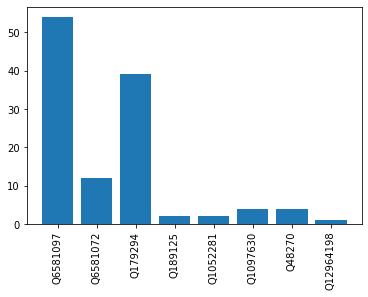

In [36]:
import matplotlib.pyplot as plt
plt.bar(genders.keys(), genders.values())
plt.xticks(rotation = 90);

In [9]:
qids = set()
for element in speaker_data[['nationality', 'gender', 'ethnic_group', 'occupation', 'party', 'academic_degree', 'candidacy', 'religion']].values.ravel():
    if element is not None:
        qids |= set(element)

In [41]:
qid_to_label_mapping = utils.get_labels_of_wikidata_ids(qids)

In [48]:
remaining = [k for k in qids if k not in qid_to_label_mapping.keys()]

utils.get_labels_of_wikidata_ids(remaining, 300, 2)

{'Q52692271': 'Q52692271',
 'Q104708160': 'Q104708160',
 'Q11490598': 'Q11490598',
 'Q66659591': 'Q66659591',
 'Q2238225': 'Q2238225',
 'Q97768140': 'Q97768140',
 'Q16287483': 'Q16287483',
 'Q13112522': 'Q13112522',
 'Q28933278': 'Q28933278',
 'Q28763030': 'Q28763030',
 'Q12142150': 'Q12142150',
 'Q71473736': 'Q71473736',
 'Q17991368': 'Q17991368',
 'Q12323666': 'Q12323666',
 'Q12722794': 'Q12722794',
 'Q3326697': 'Q3326697',
 'Q42717090': 'Q42717090',
 'Q50995955': 'Q50995955',
 'Q10541492': 'Q10541492',
 'Q47262408': 'Q47262408',
 'Q96313704': 'Q96313704',
 'Q16370640': 'Q16370640',
 'Q12305109': 'Q12305109',
 'Q1388011': 'Q1388011',
 'Q64504086': 'Q64504086',
 'Q51073528': 'Q51073528',
 'Q4201365': 'Q4201365',
 'Q4090675': 'Q4090675',
 'Q105044610': 'Q105044610',
 'Q55664265': 'Q55664265',
 'Q64884078': 'Q64884078',
 'Q11330574': 'Q11330574',
 'Q50108322': 'Q50108322',
 'Q3088490': 'Q3088490',
 'Q17612390': 'Q17612390',
 'Q64031853': 'Q64031853',
 'Q6570301': 'Q6570301',
 'Q20919317

In [35]:
speaker_data.loc[speaker_data["id"] == 'Q15735939']

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
7078648,[Christopher Douglas Matthews],[+1989-10-06T00:00:00Z],[Q30],[Q6581097],1317867389,[Q49085],None,"[Q19204627, Q19841381]",None,None,Q15735939,Chris Matthews,None,item,None


In [15]:
import requests

In [16]:
url = 'https://query.wikidata.org/sparql'
query = '''
SELECT ?item ?itemLabel ?linkcount 
WHERE {
    ?item wdt:P31/wdt:P279* wd:Q35666 .
    ?item wikibase:sitelinks ?linkcount .
    FILTER (?linkcount >= 1) .
    SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en" . }
}

GROUP BY ?item ?itemLabel ?linkcount
ORDER BY DESC(?linkcount)
'''
r = requests.get(url, params = {'format': 'json', 'query': query})
data = r.json()

In [17]:
data

{'head': {'vars': ['item', 'itemLabel', 'linkcount']},
 'results': {'bindings': [{'item': {'type': 'uri',
     'value': 'http://www.wikidata.org/entity/Q39651'},
    'itemLabel': {'xml:lang': 'en',
     'type': 'literal',
     'value': 'Eyjafjallajökull'},
    'linkcount': {'datatype': 'http://www.w3.org/2001/XMLSchema#integer',
     'type': 'literal',
     'value': '74'}},
   {'item': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q179734'},
    'itemLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Vatnajökull'},
    'linkcount': {'datatype': 'http://www.w3.org/2001/XMLSchema#integer',
     'type': 'literal',
     'value': '61'}},
   {'item': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q200255'},
    'itemLabel': {'xml:lang': 'en',
     'type': 'literal',
     'value': 'Ross Ice Shelf'},
    'linkcount': {'datatype': 'http://www.w3.org/2001/XMLSchema#integer',
     'type': 'literal',
     'value': '53'}},
   {'item': {'type': 'uri', 'value': 'http://www.w